# Binary Decision Tree

### Import Packages

In [1]:
import numpy as np
import pandas as pd
import ssl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import itertools
import random
from pprint import pprint

### Class Structure for Internal Nodes

In [2]:
class decision_node:
    
    def __init__(self):
        
        #Attribute name on which data split has taken
        self.attribute = ""
        
        #Value on the attribute which is the condition
        self.value = ""
        
        #Whether attribute is categorical or numerical
        self.feature_type = ""
        
        #Count of number of positive data samples
        self.positive = 0
        
        #Count of number of negative data samples
        self.negative = 0

### Class Structure for Leaf Nodes

In [3]:
class leaf_node:
    
    def __init__(self):
        
        #To store final result
        self.prediction = 0
        
        #Count of number of positive data samples
        self.positive = 0
        
        #Count of number of negative data samples
        self.negative = 0

## Data Preprocessing

In [35]:
def data_preprocessing(question):
    
    df = pd.read_csv("train.csv")
    df["label"] = df.left

    if question == "all":
        #For training on both continous and categorical features
        df = df.drop(["left"], axis=1)
        
    elif question == "categorical":
        #For training on only categorical features
        df = df.drop(["left","satisfaction_level","last_evaluation","number_project","average_montly_hours","time_spend_company"],axis=1)  

    #dividing dataset into positive and negative values of the label
    pos_df = df.loc[df['label'] == 0]
    neg_df = df.loc[df['label'] == 1]
    
    #spliting positive and negative dataset into randomly 80-20 % split
    pos_train_df, pos_test_df = train_test_split(pos_df, 0.2)
    neg_train_df, neg_test_df = train_test_split(neg_df, 0.2)
    
    #merging positive and negative data split so that training and validation dataset contains equal number of positive and negative value of feature label 
    train_df = pd.concat([pos_train_df, neg_train_df])
    test_df = pd.concat([pos_test_df, neg_test_df])
    
    return train_df, test_df

### Spliting dataset in test and validation set

In [40]:
#df is the data frame to split and size is the fraction on dataset in validation set
def train_test_split(df, size):
    
    if isinstance(size, float):
        size = round(size * len(df))
    
    #getting indexes of dataset in a list
    indices = df.index.tolist()
    
    #randomly choosing "size" number of indices for validation set
    indices = random.sample(population=indices, k=size)

    #Creating validation set
    validation_df = df.loc[indices]
    
    #Creating trianing set
    train_df = df.drop(indices)
    
    return train_df, validation_df

### Build Tree Logic

In [6]:
def build_tree(data, impurity_measure = "gini", counter = 0, min_rows = 3, max_depth = 8, no_of_node = []):
    
    #To determine next best split column and its value based on which split has to be done
    split_column, split_value = determine_split(data,impurity_measure)
    
    #base condition
    if ((split_column == "") or check_purity_data(data)) or (len(data) < min_rows) or (counter == max_depth) or (no_of_node[0] <= 0):
        
        #Creating leaf node object
        leaf = leaf_node()
        
        #positive means employee will leave
        #negative means employee will not leave
        leaf.prediction, leaf.positive, leaf.negative = classify_data(data)
        return leaf
    
    
    #Spliting dataset based on split_column and split_value
    left_child_data, right_child_data = split_data(data, split_column, split_value)

    feature_name = COLUMN_HEADERS[split_column]
    type_of_feature = FEATURE_TYPES[split_column]

    #Creating internal node object
    node = decision_node()
    node.attribute = feature_name
    node.feature_type = type_of_feature
    node.value = split_value
    temp, node.positive, node.negative = classify_data(data)
    
    #list object to keep track of number of number of nodes in decion tree so far
    no_of_node[0] = no_of_node[0]-1
    
    #Recursive call on left child
    left_child = build_tree(left_child_data, impurity_measure ,counter+1, min_rows, max_depth, no_of_node)
    
    #Recursive call on right child
    right_child = build_tree(right_child_data,impurity_measure, counter+1, min_rows, max_depth, no_of_node)

    #keeping reference of left and right child
    node.left = left_child
    node.right = right_child
    
    return node

### Classification Procedure

In [7]:
def dt_classifier(test_row, tree):
    
    #Checking whether we have reached leaf node
    if isinstance(tree, leaf_node):
        return tree.prediction

    #Extracting feature name, value and feature type
    feature_name = tree.attribute
    value = tree.value
    feature_type = tree.feature_type
    
    
    #For continuous feature type
    if feature_type == "continuous":
        
        #Condition to recurse to left child
        if test_row[feature_name] <= float(value) and tree.left != None:
            return dt_classifier(test_row, tree.left)
        
        #Condition to recurse to right child
        elif tree.right!= None:
            return dt_classifier(test_row, tree.right)
        
        #Condition if both left and right child does not exits and we are not at leaf which is possible in case of pruning
        else:
            if tree.positive > tree.negative:
                return "1"
            else:
                return "0"
    
    elif feature_type == "categorical":
        
        #Condition to recurse to left child
        if str(test_row[feature_name]) == value and tree.left != None:
            return dt_classifier(test_row, tree.left)
        
        #Condition to recurse to right child
        elif tree.right!= None:
            return dt_classifier(test_row, tree.right)
        
        #Condition if both left and right child does not exits and we are not at leaf which is possible in case of pruning
        else:
            if tree.positive > tree.negative:
                return "1"
            else:
                return "0"
                          

## Utility Functions

In [8]:
#To check whether the label column contains only one distinct value or not
def check_purity_data(data):
    
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        #if label is pure i.e. contains only one distinct value
        return True  
    else:
        return False

In [9]:
#To find number occurrences of dictinct values in label feature and to return values with maximum occurence and count of all distinct values
def classify_data(data):
    
    #Accessing lebal column
    label_column = data[:, -1]
    
    #Finding unique classes and the count
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    #Finding value with maximum count/occurence
    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    positives = 0
    negatives = 0
    
    #Find count of each distinct values in label columns
    for item in label_column:
        if item == 1:
            positives += 1
        else:
            negatives += 1
    
    return classification, positives, negatives 

In [10]:
#To split data based on a particular unique value of a particular feature
def split_data(data, split_column, split_value):
    
    #Get all the values of the feature
    split_column_values = data[:, split_column]
    
    #Get feature type which can be either continuous or categorical 
    type_of_feature = FEATURE_TYPES[split_column]
    
    #For continuous feature
    if type_of_feature == "continuous":
        left_data = data[split_column_values <= split_value]
        right_data = data[split_column_values >  split_value]
    
    #For categorical feature
    else:
        left_data = data[split_column_values == split_value]
        right_data = data[split_column_values != split_value]
    
    return left_data, right_data

In [97]:
#Function to find feature and  its unique value which provides best split information gain 
def determine_split(data,impurity_measure):
    
    #To store all split points possible for the current dataset
    potential_splits = {}
    
    #To get number of columns in numpy ndarray
    no_of_columns = data.shape[1]
    
    #Looping on all features and storing all unique values as split points except on label feature
    for column_index in range(no_of_columns - 1):          
    
        values = data[:, column_index]
        
        #To get all the unique values of a feature
        unique_values = np.unique(values)
        
        #To get feature type which can be either categorical or continuous
        type_of_feature = FEATURE_TYPES[column_index]
        
        if type_of_feature == "continuous":
            potential_splits[column_index] = []
            
            #For continuous we store the mid point of all consecutive unique value as potential split point
            for index in range(len(unique_values)):
                if index != 0:
                    current_value = unique_values[index]
                    previous_value = unique_values[index - 1]
                    potential_split = (current_value + previous_value)/2

                    potential_splits[column_index].append(potential_split)
                    
        #For categorical feature we only take those feature whose number of unique values are greater than one so that we don't recurse on same feature again and again
        elif type_of_feature == "categorical" and len(unique_values) > 1:
            potential_splits[column_index] = unique_values
    
    #To get present impurity present in dataset based on label feature
    present_impurity = get_impurities(data,impurity_measure)
    
    current_info_gain = 0
    info_gain = float('-inf')
    
    best_split_column = ""
    best_split_value = 0
    
    #To calculate information gain for every feature in potential splits dictionary
    for column_index in potential_splits:
        
        #For every unique value of a feature
        for value in potential_splits[column_index]:
            
            #spliting data into two part
            left_child_data, right_child_data = split_data(data, split_column=column_index, split_value=value)
            
            #Calculating impurity based on impurity measure
            if impurity_measure == "entropy":
                current_overall_impurity = calculate_entropy(left_child_data, right_child_data)
            elif impurity_measure == "gini":
                current_overall_impurity = calculate_gini(left_child_data, right_child_data)
            elif impurity_measure == "misclassification":
                current_overall_impurity = calculate_misclassification(left_child_data, right_child_data)
                
            #Calculating information gain    
            current_info_gain = present_impurity - current_overall_impurity    
                
            #Storing feature name and feature value which provides maximum information gain    
            if current_info_gain >= info_gain:
                info_gain = current_info_gain
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

In [12]:
#To get impurity of dataset based on a particular impurity measure
def get_impurities(data, impurity_measure):
    
    if impurity_measure == "entropy":
        return entropy(data)
    elif impurity_measure == "gini":
        return gini(data)
    elif impurity_measure == "misclassification":
        return misclassification(data)

In [13]:
#To segregate continuous feature and categorical feature based on a threshold value
def determine_feature_type(df):
    
    feature_types = []
    
    #Threshlod value which determines if number of unique values id 
    unique_values_treshold = 5
    for feature in df.columns:
        
        #We assume that label feature is categorical otherwise it cannot be a classification problem
        if feature != "label":
            
            #Find unique values of a features
            unique_values = df[feature].unique()
            value = unique_values[0]

            #if value is string then it has to be categorical or if no of unique values is less than threshold
            if (isinstance(value, str)) or (len(unique_values) <= unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

## Impurity Measure Functions

### Entropy Calculation

In [14]:
#To calculate entropy of dataset based on label feature only
def entropy(data):
    
    #Extracting label feature column
    label_column = data[:, -1]
    
    #Extracting all unique values of label feature column
    columns , counts = np.unique(label_column, return_counts=True)

    #Calculating probability of each unique value of label feature
    probabilities = counts / counts.sum()
    
    #Calculating entropy for every element in the list and taking there sum
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

In [15]:
#To calculate entropy of data of left data and right data
def calculate_entropy(left_data, right_data):
    
    #To calculate total length of data which is to be split
    n = len(left_data) + len(right_data)
    
    #To calculate weight of left child data
    probabilty_left_data = len(left_data)/n
    
    #To calculate weight of right child data
    probabilty_right_data = len(right_data)/n

    #To calculate overall entropy of a particular feature based on which data got split
    feature_entropy =  (probabilty_left_data * entropy(left_data) + probabilty_right_data * entropy(right_data))
    
    return feature_entropy

### Gini Calculation

In [16]:
#To calculate gini of dataset based on label feature only
def gini(data):

    #Extracting label feature column
    label_column = data[:, -1]
    
    #Extracting all unique values of label feature column
    columns, counts = np.unique(label_column, return_counts=True)

    gini = 1
    
    #Calculating probability of each unique value of label feature
    probabilities = counts / counts.sum()
    
    #Calculating gini for every element in the list and taking there sum
    impurity = sum(probabilities **2)
    gini -= impurity
        
    return gini

In [17]:
#To calculate gini of data of left data and right data
def calculate_gini(left_data, right_data):
    
    #To calculate total length of data which is to be split
    n = len(left_data) + len(right_data)
    
    #To calculate weight of left child data
    probabilty_left_data = len(left_data)/n
    
    #To calculate weight of right child data
    probabilty_right_data = len(right_data)/n

    #To calculate overall gini of a particular feature based on which data got split
    feature_gini =  (probabilty_left_data * gini(left_data) + probabilty_right_data * gini(right_data))
    
    return feature_gini

### Miscalssification Calculation

In [18]:
#To calculate misclassification of dataset based on label feature only
def misclassification(data):

    #Extracting label feature column
    label_column = data[:, -1]
    
    #Extracting all unique values of label feature column
    columns, counts = np.unique(label_column, return_counts=True)

    #Calculating probability of each unique value of label feature
    probabilities = counts / counts.sum()
    
    misclassification = 1 - max(probabilities)
    
    return misclassification
    

In [19]:
#To calculate misclassification of data of left data and right data
def calculate_misclassification(left_data, right_data):
    
    #To calculate total length of data which is to be split
    n = len(left_data) + len(right_data)
    
    #To calculate weight of left child data
    probabilty_left_data = len(left_data)/n
    
    #To calculate weight of right child data
    probabilty_right_data = len(right_data)/n

    #To calculate overall misclassification of a particular feature based on which data got split
    feature_misclassification =  (probabilty_left_data * misclassification(left_data) + probabilty_right_data * misclassification(right_data))
    
    return feature_misclassification

## Result Analysis Functions

### Confusion Matrix

In [74]:
def print_confusion_matrix(df):
    
    #to count true positive
    count_TP = 0
    
    #to count false positive
    count_FP = 0
    
    #to count false negative
    count_FN = 0
    
    #to count true negative
    count_TN = 0
    
    for index, row in df.iterrows():
        if row["result"] == row["label"] and row["label"] == 1:
            count_TP += 1
        elif row["result"] == row["label"] and row["label"] == 0:
            count_TN += 1    
        elif row["result"] == 1 and row["label"] == 0:
            count_FP += 1
        elif row["result"] == 0 and row["label"] == 1:    
            count_FN += 1
            
    print("True Positive: ", count_TP)
    print("True Negative: ", count_TN)
    print("False Positive: ", count_FP)
    print("False Negative: ", count_FN)

### F1 Score Calculation

In [21]:
def calculate_f1_score(df):
    
    precision = calculate_precision(df)
    recall = calculate_recall(df)
    
    #If recall and precision is both 0 then f1 score is undefined
    if precision == 0 or recall == 0:
        return 0
    
    #calculate f1 score
    f1_score = 2*((precision*recall)/(precision+recall))

    return f1_score


### Accuracy Calculation

In [42]:
def calculate_accuracy(df):
    
    #mean of all results
    accuracy = df["correct_result"].mean()
    
    return accuracy

### Precision Calculation

In [43]:
def calculate_precision(df):

    #to count true positive
    count_TP = 0
    
    #to count false positive
    count_FP = 0
    
    for index, row in df.iterrows():
        if row["result"] == row["label"] and row["label"] == 1:
            count_TP += 1
        elif row["result"] == 1 and row["label"] == 0:
            count_FP += 1
    
    #To check whether precision is defined or not. If not then return 0
    if count_TP == 0 and count_FP == 0 :
        return 0
    
    precision = (count_TP)/(count_TP + count_FP)
    
    return precision       

### Recall Calculation

In [44]:
def calculate_recall(df):
    
    #to count true positive
    count_TP = 0
    
    #to count false negative
    count_FN = 0
    
    for index, row in df.iterrows():
        if row["result"] == row["label"] and row["label"] == 1:
            count_TP += 1
        elif row["result"] == 0 and row["label"] == 1:    
            count_FN += 1
    
    #To check whether precision is defined or not. If not then return 0
    if count_TP == 0 and count_FN == 0 :
        return 0
    
    recall = (count_TP)/(count_TP + count_FN)
    
    return recall        

## Data Visualisation

### Plotting Features 

In [128]:
def plot_features():
    
    #read data from csv file
    df = pd.read_csv("train.csv")
    
    #Visualisation
    sns.catplot(y="time_spend_company", x="number_project", hue="left", data=df);
    sns.catplot(y="satisfaction_level", x="left",kind="box", hue="number_project", data=df);
    sns.catplot(y="satisfaction_level", x="left", hue="time_spend_company", kind = "box",data=df);
    sns.catplot(y="time_spend_company", x="left",hue="promotion_last_5years", kind = "box",data=df);
    sns.catplot(y="time_spend_company", x="left",hue="sales", kind = "box",data=df);
    sns.catplot(y="average_montly_hours", x="left",hue="promotion_last_5years", kind = "box",data=df);
    sns.catplot(y="average_montly_hours", x="left",hue="promotion_last_5years", data=df);
    sns.catplot(y="satisfaction_level", x="left",hue="promotion_last_5years", data=df);
    sns.catplot(y="satisfaction_level", x="left",hue="Work_accident", data=df);
    sns.catplot(y="satisfaction_level", x="left", hue="time_spend_company", data=df);
    sns.catplot(y="satisfaction_level", x="left", hue="number_project", data=df.query("number_project != 3"));
    sns.catplot(y="satisfaction_level", x="left", hue="number_project", data=df);
    sns.catplot(y="satisfaction_level", x="left",kind="swarm", hue="number_project",data=df);

### Error vs Tree Depth

In [131]:
#We iterate from 1 to max_depth to generate error vs depth plot
def error_vs_tree_depth(question, max_depth):
    

    entropy = []
    gini = []
    misclassification = []
    
    Depth = []


    for i in range(max_depth):

        
        Depth.append(i+1)
        
        #splitting dataset into train and validation set
        train_df,validation_df = data_preprocessing(question)
        
        global COLUMN_HEADERS, FEATURE_TYPES
        
        #storing cloumn header in a global varibale
        COLUMN_HEADERS = train_df.columns

        #Generating feature type for each column
        FEATURE_TYPES = determine_feature_type(train_df)
        
        #For entropy
        nodes = []
        nodes.append(10000) #randomly large value
        
        #building tree
        tree = build_tree(train_df.values,"entropy",0,8,i+1,nodes)

        #Classifiaction of validation data
        validation_df["result"] = validation_df.apply(dt_classifier, args=(tree,), axis=1)
        validation_df["correct_result"] = validation_df["result"] == validation_df["label"]
        
        entropy.append((1 - calculate_accuracy(validation_df)))
        
        del nodes
        
        
        #For Gini
        nodes = []
        nodes.append(10000) #randomly large value
        
        #building tree
        tree = build_tree(train_df.values,"gini",0,8,i+1,nodes)

        #Classifiaction of validation data
        validation_df["result"] = validation_df.apply(dt_classifier, args=(tree,), axis=1)
        validation_df["correct_result"] = validation_df["result"] == validation_df["label"]
        
        gini.append((1 - calculate_accuracy(validation_df)))
        
        del nodes
        
        #For Misclassification
        
        nodes = []
        nodes.append(10000) #randomly large value
        
        #building tree
        tree = build_tree(train_df.values,"misclassification",0,8,i+1,nodes)

        #Classifiaction of validation data
        validation_df["result"] = validation_df.apply(dt_classifier, args=(tree,), axis=1)
        validation_df["correct_result"] = validation_df["result"] == validation_df["label"]
        
        misclassification.append((1 - calculate_accuracy(validation_df)))
        
        del nodes
    
    
    
    
    depth = pd.DataFrame(
        {'Depth': Depth,
         'Entropy': entropy,
         'Gini': gini,
         'Misclassification': misclassification
        })
    
    #Error visualisation
    depth = depth.melt('Depth', var_name='Impurity Measure',  value_name='Error')
    depth_graph = sns.factorplot(x="Depth", y="Error", hue='Impurity Measure', data=depth)
        

### Error vs Tree Nodes

In [130]:
def error_vs_tree_nodes(question, n):
    
#     df = {}
    nodes = []

    entropy = []
    gini = []
    misclassification = []
    Nodes = []

    
    for i in range(0,n,100):

        Nodes.append(i+1)
        
        #splitting dataset into train and validation set
        train_df,validation_df = data_preprocessing(question)
        
        global COLUMN_HEADERS, FEATURE_TYPES
        
        #storing cloumn header in a global varibale
        COLUMN_HEADERS = train_df.columns

        #Generating feature type for each column
        FEATURE_TYPES = determine_feature_type(train_df)
        
        #For Entropy 
        nodes = []
        nodes.append(i+1)
        
        #building tree
        tree = build_tree(train_df.values,"entropy",0,8,400,nodes)
        
        #Classifiaction of validation data
        validation_df["result"] = validation_df.apply(dt_classifier, args=(tree,), axis=1)
        validation_df["correct_result"] = validation_df["result"] == validation_df["label"]
        
        entropy.append((1 - calculate_accuracy(validation_df)))
        del nodes

        #For Gini
        nodes = []
        nodes.append(i+1)
        
        #building tree
        tree = build_tree(train_df.values,"gini",0,8,400,nodes)
        
        #Classifiaction of validation data
        validation_df["result"] = validation_df.apply(dt_classifier, args=(tree,), axis=1)
        validation_df["correct_result"] = validation_df["result"] == validation_df["label"]
        
        gini.append((1 - calculate_accuracy(validation_df)))
        del nodes
        
        
        #For Misclassification
        nodes = []
        nodes.append(i+1)
        
        #building tree
        tree = build_tree(train_df.values,"misclassification",0,8,400,nodes)
        
        #Classifiaction of validation data
        validation_df["result"] = validation_df.apply(dt_classifier, args=(tree,), axis=1)
        validation_df["correct_result"] = validation_df["result"] == validation_df["label"]
        
        misclassification.append((1 - calculate_accuracy(validation_df)))
        del nodes
        
    node = pd.DataFrame(
    {'Nodes': Nodes,
     'Entropy': entropy,
     'Gini': gini,
     'Misclassification': misclassification
    })
    
    #Error visualisation
    node = node.melt('Nodes', var_name='Impurity Measure',  value_name='Error')
    node_graph = sns.factorplot(x="Nodes", y="Error", hue='Impurity Measure', data=node)
        

### Error vs Minimum Number of Rows

In [132]:
def error_vs_min_rows(question, n):
    

    entropy = []
    gini = []
    misclassification = []
    Minimum_Rows = []
    
    
    for i in range(0,n,1):
        
        Minimum_Rows.append(i+1)
        
        nodes = []
        nodes.append(400)
        
        #splitting dataset into train and validation set
        train_df,validation_df = data_preprocessing(question)
        
        global COLUMN_HEADERS, FEATURE_TYPES
        
        #storing cloumn header in a global varibale
        COLUMN_HEADERS = train_df.columns

        #Generating feature type for each column
        FEATURE_TYPES = determine_feature_type(train_df)
        
        #building tree
        tree = build_tree(train_df.values,"entropy",0,i+1,400,nodes)
        
        #Classification of validation data
        validation_df["result"] = validation_df.apply(dt_classifier, args=(tree,), axis=1)
        validation_df["correct_result"] = validation_df["result"] == validation_df["label"]
        
        entropy.append((1 - calculate_accuracy(validation_df)))
        del nodes
        
        
        nodes = []
        nodes.append(400)
        
        #building tree
        tree = build_tree(train_df.values,"gini",0,i+1,400,nodes)
        
        #Classification of validation data
        validation_df["result"] = validation_df.apply(dt_classifier, args=(tree,), axis=1)
        validation_df["correct_result"] = validation_df["result"] == validation_df["label"]
        
        gini.append((1 - calculate_accuracy(validation_df)))
        del nodes
        
        
        nodes = []
        nodes.append(400)
        
        #building tree
        tree = build_tree(train_df.values,"misclassification",0,i+1,400,nodes)
        
        #Classification of validation data
        validation_df["result"] = validation_df.apply(dt_classifier, args=(tree,), axis=1)
        validation_df["correct_result"] = validation_df["result"] == validation_df["label"]
        
        misclassification.append((1 - calculate_accuracy(validation_df)))
        del nodes

    min_rows = pd.DataFrame(
    {'Minimum_Rows': Minimum_Rows,
     'Entropy': entropy,
     'Gini': gini,
     'Misclassification': misclassification
    })
    
    #Error visualisation
    min_rows = min_rows.melt('Minimum_Rows', var_name='Impurity Measure',  value_name='Error')
    min_rows_graph = sns.factorplot(x="Minimum_Rows", y="Error", hue='Impurity Measure', data=min_rows)
    


### Entropy, Gini, Misclassification vs Accuracy, Precision, Recall, F1 Score

In [100]:
def compare_metrics(question):
    
    entropy_accuracy = []
    gini_accuracy = []
    misclassification_accuracy = []
    
    entropy_precision = []
    gini_precision = []
    misclassification_precision = []
    
    entropy_recall = []
    gini_recall = []
    misclassification_recall = []
    
    entropy_f1_score = []
    gini_f1_score = []
    misclassification_f1_score = []
    
    iterations = []
    
    nodes = []

    for i in range(10):
        
        iterations.append(i+1)    
        
        train_df, validation_df = data_preprocessing(question)
    
        global COLUMN_HEADERS, FEATURE_TYPES
        
        #storing cloumn header in a global varibale
        COLUMN_HEADERS = train_df.columns

        #Generating feature type for each column
        FEATURE_TYPES = determine_feature_type(train_df)
    
    
        nodes = []
        nodes.append(400)
        tree = build_tree(train_df.values,"entropy",0,3,8,nodes)
        del nodes
        
        #Classifiaction of validation data
        validation_df["result"] = validation_df.apply(dt_classifier, args=(tree,), axis=1)
        validation_df["correct_result"] = validation_df["result"] == validation_df["label"]
        
        
        entropy_accuracy.append(calculate_accuracy(validation_df))
        entropy_precision.append(calculate_precision(validation_df))
        entropy_recall.append(calculate_recall(validation_df))
        entropy_f1_score.append(calculate_f1_score(validation_df))
        
        nodes = []
        nodes.append(400)
        tree = build_tree(train_df.values,"gini",0,3,8,nodes)
        del nodes
        
        #Classifiaction of validation data
        validation_df["result"] = validation_df.apply(dt_classifier, args=(tree,), axis=1)
        validation_df["correct_result"] = validation_df["result"] == validation_df["label"]
        gini_accuracy.append(calculate_accuracy(validation_df))
        gini_precision.append(calculate_precision(validation_df))
        gini_recall.append(calculate_recall(validation_df))
        gini_f1_score.append(calculate_f1_score(validation_df))
        
        nodes = []
        nodes.append(400)
        tree = build_tree(train_df.values,"misclassification",0,3,8,nodes)
        del nodes
        
        #Classifiaction of validation data
        validation_df["result"] = validation_df.apply(dt_classifier, args=(tree,), axis=1)
        validation_df["correct_result"] = validation_df["result"] == validation_df["label"]
        misclassification_accuracy.append(calculate_accuracy(validation_df))
        misclassification_precision.append(calculate_precision(validation_df))
        misclassification_recall.append(calculate_recall(validation_df))
        misclassification_f1_score.append(calculate_f1_score(validation_df))
        
      
    #Creating dataframe for accuracy data
    accuracy = pd.DataFrame(
    {'Iterations': iterations,
     'Entropy': entropy_accuracy,
     'Gini': gini_accuracy,
     'Misclassification': misclassification_accuracy
    })
    
    #Accuracy visualisation
    accuracy = accuracy.melt('Iterations', var_name='Impurity Measure',  value_name='Accuracy')
    accuracy_graph = sns.factorplot(x="Iterations", y="Accuracy", hue='Impurity Measure', data=accuracy)
    
    #Creating dataframe for precision data
    precision = pd.DataFrame(
    {'Iterations': iterations,
     'Entropy': entropy_precision,
     'Gini': gini_precision,
     'Misclassification': misclassification_precision
    })

    #Precision visualisation
    precision = precision.melt('Iterations', var_name='Impurity Measure',  value_name='Precision')
    precision_graph = sns.factorplot(x="Iterations", y="Precision", hue='Impurity Measure', data=precision)
    
    #Creating dataframe for recall data
    recall = pd.DataFrame(
    {'Iterations': iterations,
     'Entropy': entropy_recall,
     'Gini': gini_recall,
     'Misclassification': misclassification_recall
    })

    #Recall visualisation
    recall = recall.melt('Iterations', var_name='Impurity Measure',  value_name='Recall')
    recall_graph = sns.factorplot(x="Iterations", y="Recall", hue='Impurity Measure', data=recall)
    
    #Creating dataframe for f1 score data
    f1_score = pd.DataFrame(
    {'Iterations': iterations,
     'Entropy': entropy_f1_score,
     'Gini': gini_f1_score,
     'Misclassification': misclassification_f1_score
    })

    #F1 Score visualisation
    f1_score = f1_score.melt('Iterations', var_name='Impurity Measure',  value_name='F1 Score')
    f1_score_graph = sns.factorplot(x="Iterations", y="F1 Score", hue='Impurity Measure', data=f1_score)
    

## Training and Evaluation

In [50]:
def train_model(question):
    
    #Parameters and there value at which we obtain maximum accuracy 
    impurity_measure = "gini"
    min_rows = 8
    depth = 8
    max_nodes = []
    max_nodes.append(400)
    
    
    global COLUMN_HEADERS, FEATURE_TYPES
    
    #data preprocessing to split dataset to train and validation set
    train_df, validation_df = data_preprocessing(question)
    
    #storing cloumn header in a global varibale
    COLUMN_HEADERS = train_df.columns
    
    #Generating feature type for each column
    FEATURE_TYPES = determine_feature_type(train_df)
    
    #converting pandas data frame to numpy array
    data = train_df.values
    
    #build tree function invocation
    tree = build_tree(data,impurity_measure,0,min_rows,depth,max_nodes)
    
    del max_nodes
    
    return tree

In [87]:
def evaluation(question):
    
    #Train decision tree
    tree = train_model(question)
    
    #Read test data from file
    test_df = pd.read_csv("test.csv")

    #Neccessary preprocessing
    test_df["label"] = test_df.left

    if question == "all":
        #For training on both continous and categorical features
        test_df = test_df.drop(["left"], axis=1)
        
    elif question == "categorical":
        #For training on only categorical features
        test_df = test_df.drop(["left","satisfaction_level","last_evaluation","number_project","average_montly_hours","time_spend_company"],axis=1)  

    
    #Applying classification
    test_df["result"] = test_df.apply(dt_classifier, args=(tree,), axis=1)
    test_df["correct_result"] = test_df["result"] == test_df["label"]

    #Calculating accuracy
    accuracy = calculate_accuracy(test_df)
    
    #Calculating precision
    precision = calculate_precision(test_df)
    
    #Calculating recall
    recall = calculate_recall(test_df)
    
    #Calculating f1 score
    f1_score = calculate_f1_score(test_df)

    #Print confusion matrix
    print_confusion_matrix(test_df)
    
    print("Accuracy: ",accuracy)
    print("Precision: ",precision)
    print("Recall: ",recall)
    print("F1 Score: ",f1_score)

### Question 1 - 1

In [88]:
evaluation("categorical")

True Positive:  0
True Negative:  62
False Positive:  0
False Negative:  8
Accuracy:  0.8857142857142857
Precision:  0
Recall:  0.0
F1 Score:  0


### Question 1 - 2

In [89]:
evaluation("all")

True Positive:  6
True Negative:  62
False Positive:  0
False Negative:  2
Accuracy:  0.9714285714285714
Precision:  1.0
Recall:  0.75
F1 Score:  0.8571428571428571


### Question 1 - 3

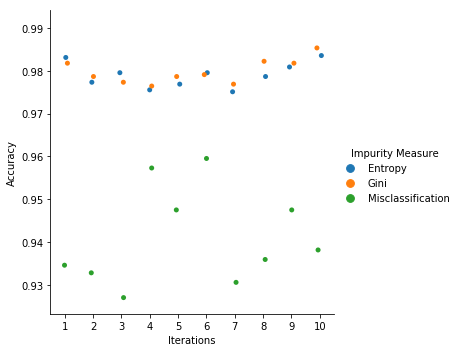

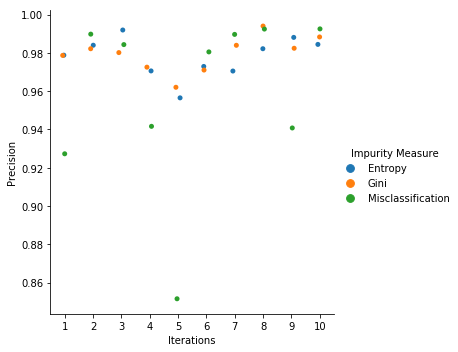

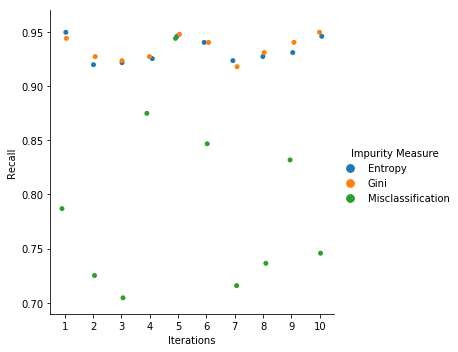

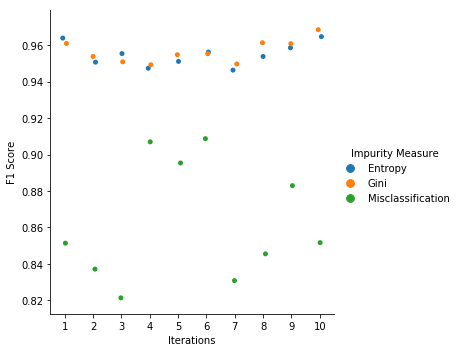

In [92]:
compare_metrics("all")

### Question 1 - 4

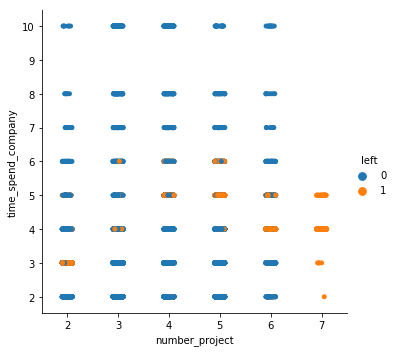

In [129]:
plot_features()

### Question 1 - 5 - 1

/home/prakashjha/.local/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


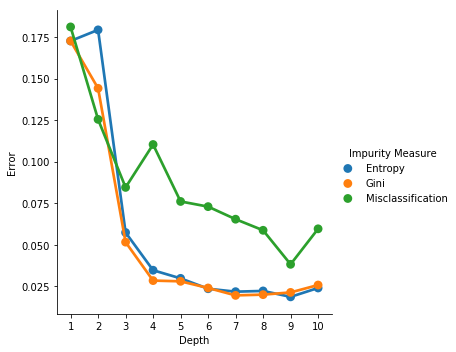

In [117]:
error_vs_tree_depth("all",10)

### Question 1 - 5 - 2 

/home/prakashjha/.local/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


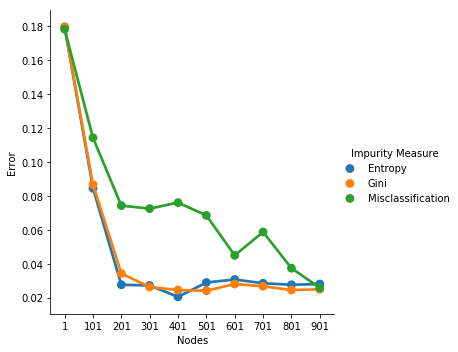

In [121]:
error_vs_tree_nodes("all",1000)

### Question 1 - 5 - 3

/home/prakashjha/.local/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


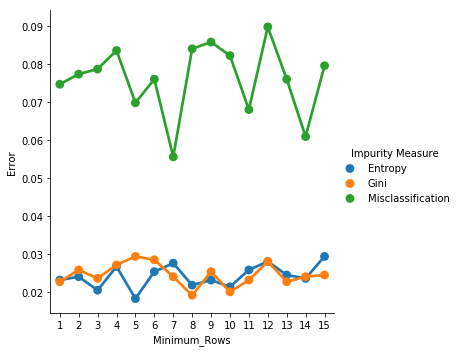

In [115]:
error_vs_min_rows("all", 15)